# Exploring Content-Based Recommendation Systems in Bipartite Graphs

This notebook investigates content-based recommendation systems within bipartite graphs. These systems utilize object similarity to predict unobserved edges, offering the potential for improved recommendation accuracy and an enhanced user experience. We explore the fundamentals of this approach, where object attributes and relationships are leveraged to create tailored suggestions. Central to our investigation is the assumption of similarity between objects, which forms the bedrock for predicting associations. By estimating unobserved connections through observed ones, we highlight the effectiveness of this method and its significance in the landscape of personalization and content consumption. This work sheds light on the mechanisms underpinning content-based recommendation systems and their potential to redefine user interactions with digital content.


In [1]:
# In this notebook, we will try to estimate the objective function of
# two complex attributes. Each attribute should be embedded before
# being used in the objective function. 
# Finally, we will test that given one attribute, find the other one
# such that the objective function is maximized.

In [2]:
# good reference:
# How to estimate other attributes given one attribute
# https://stackoverflow.com/a/43402975/5441945
# https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


## Load the data
Here we "abalone" dataset for a demonstration and we just use its features.
We divide the features into two sets and assume that the features in each set
are correlated. We want to estimate the objective function of the features,
which represents the edge weights between the two sets of nodes.
Later we defined an arbitrary objective function of the features, which represents
the edge weights between the two sets of nodes.

> **TODO**: use a dataset for recommendation systems

In [4]:
# load a dataset from internet
from ucimlrepo import fetch_ucirepo

# fetch dataset 
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes) 

X = abalone.data.features.to_numpy()
abalone.data.features.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [5]:
rng = np.random.default_rng(12345)

In [6]:
attr1 = X[:, 1:4].astype(np.float32)
attr2 = X[:, 4:8].astype(np.float32)
attr1_dimension = attr1.shape[1]
attr2_dimension = attr2.shape[1]

In [7]:
# # hack attr1 and attr2 as meshgrid from 0 to 1 and preserve the original shape
# attr1 = rng.random((100000, attr1_dimension)) * (attr1.max(axis=0)-attr1.min(axis=0)) + attr1.min(axis=0)
# attr2 = rng.random((100000, attr2_dimension)) * (attr2.max(axis=0)-attr2.min(axis=0)) + attr2.min(axis=0)

In [8]:
pd.DataFrame(attr1).describe()

,0,1,2
count,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516
std,0.120093,0.099240,0.041827
min,0.075000,0.055000,0.000000
25%,0.450000,0.350000,0.115000
50%,0.545000,0.425000,0.140000
75%,0.615000,0.480000,0.165000
max,0.815000,0.650000,1.130000


In [9]:
# The objective function of the two attributes
# To make the problem simple, we assume that the objective function is convex.
# So we can have a better understanding of the problem.

def real_objective(arr1, arr2):
    # return a complex arbitrary function of arr1 and arr2
    # quadratic term with maximum at attr2 = [1.3, 0.7, 0.4, 0.5]
    quadratic_term = (arr2[:,0]-1.3)**2 + 5*(arr2[:,0]-1.3)**4 + 2*(arr2[:,1]-0.7)**2 + 6*(arr2[:,2]-0.4)**2 + 8*(arr2[:,3]-0.5)**2
    # This line of code is a cross term between arr1 and arr2
    # We don't use it because we want to keep this example simple
    # so we can control the optimal value of arr2 be [1.3, 0.7, 0.4, 0.5]
    # quadratic_term += arr1[:,0]*arr2[:,0] + 3*arr1[:,1]*arr2[:,1] + 2*arr1[:,2]*arr2[:,2]
    return np.sum(arr1, axis=1) + 3*np.cos(arr1[:, 0]) + 2*np.cos(arr1[:, 1]) - quadratic_term


In [10]:
y_true = real_objective(attr1, attr2)
data_df = pd.DataFrame(np.concatenate((attr1, attr2, y_true.reshape(-1, 1)), axis=1), columns=[*abalone.data.features.columns.to_list()[1:], 'y_true'])
data_df.head(100)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,y_true
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.983269
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,-5.307892
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2.891132
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1.096380
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,-6.058255
...,...,...,...,...,...,...,...,...
95,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,5.303749
96,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,3.355541
97,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,1.173012
98,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,1.254179


In [11]:
data_df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,y_true
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,1.503618
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,4.632471
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,-25.620235
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,-0.219786
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,3.633566
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,4.885039
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,5.438484


In [12]:
# split the data into train and test
from sklearn.model_selection import train_test_split
# attr1_train, attr1_test, attr2_train, attr2_test, y_true_train, y_true_test = train_test_split(attr1, attr2, y_true, test_size=0.2, random_state=123)

# Hack the data to make the problem simple: no train and test
attr1_train, attr1_test, attr2_train, attr2_test, y_true_train, y_true_test = attr1, attr1, attr2, attr2, y_true, y_true


# Build a model to estimate the objective function
We found that in this simple dataset, add more complex layers doesn't help.
For example, if we add shortcut connections between the input and the output,
the model rarely results in better accuracy,
and even it does, the downstream task is solved worse.

> **TODO**: try to do some experiments to demonstrate the above statement. Next, try to use a more complex dataset to see if the above statement is still true. If it is, try to find out why.

In [13]:
# Define the model
def build_model():
    ttl_dimension = attr1_dimension + attr2_dimension
    input1 = layers.Input(shape=(attr1_dimension,), name='attr1')
    input2 = layers.Input(shape=(attr2_dimension,), name='attr2')
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(input1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.BatchNormalization()(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.BatchNormalization()(emb1)
    # 
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(input2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.BatchNormalization()(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.BatchNormalization()(emb2)
    
    x = layers.Concatenate()([input1, input2])
    for i in range(8):
        x = layers.Dense(ttl_dimension, activation='relu')(x)
        x = layers.Dense(ttl_dimension, activation='relu')(x)
        x = layers.BatchNormalization(name=f'batch{i}')(x)
    # x = layers.Concatenate()([x, input1, input2])
    # x = layers.Dense(ttl_dimension, activation='relu')(x)
    # x = layers.Dense(ttl_dimension, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    output = layers.Dense(1, activation='linear', name='predicted_y')(x)
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError())
    return model


In [14]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attr1 (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 attr2 (InputLayer)             [(None, 4)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7)            0           ['attr1[0][0]',                  
                                                                  'attr2[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 7)            56          ['concatenate[0][0]']        

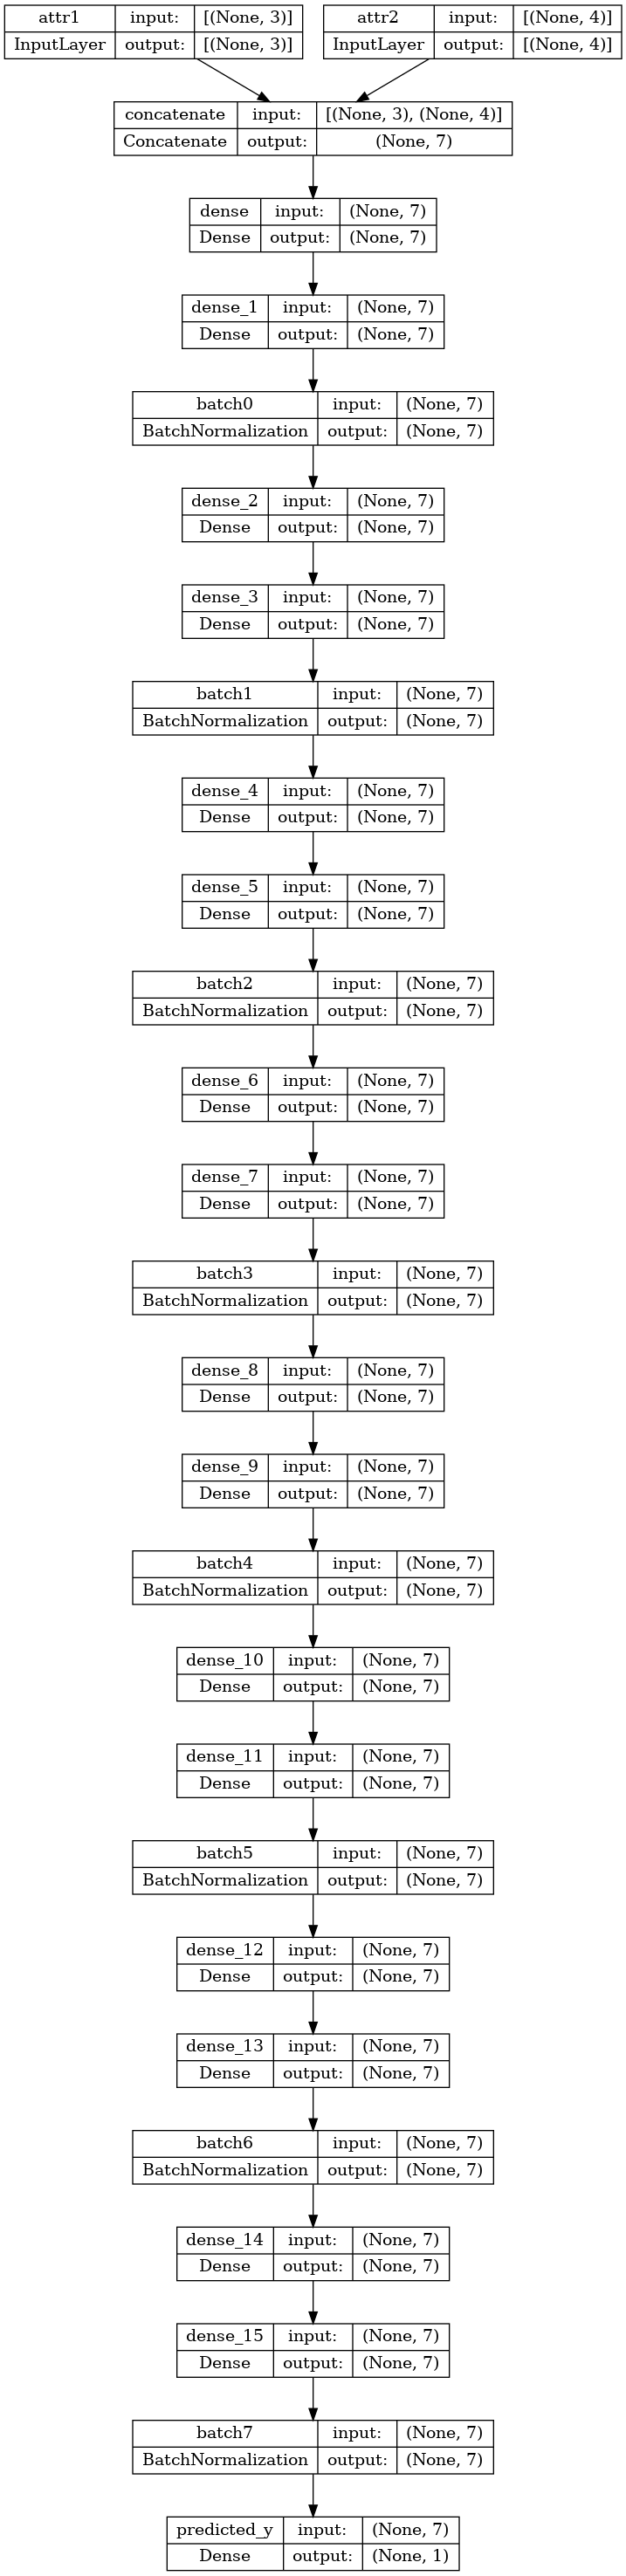

In [15]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [16]:
# Train the model with validation
early_stopping = EarlyStopping(monitor='loss', patience=80, verbose=1)
model.fit({'attr1': attr1_train, 'attr2': attr2_train}, y_true_train, epochs=1000, batch_size=1024, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/1000
4/4 [==============================] - 5s 77ms/step - loss: 21.4202 - val_loss: 22.6524
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 19.4542 - val_loss: 22.5566
Epoch 3/1000
4/4 [==============================] - 0s 17ms/step - loss: 16.7374 - val_loss: 22.4438
Epoch 4/1000
4/4 [==============================] - 0s 17ms/step - loss: 14.3595 - val_loss: 22.3500
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 12.1836 - val_loss: 22.2484
Epoch 6/1000
4/4 [==============================] - 0s 15ms/step - loss: 10.6600 - val_loss: 22.0810
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 9.2639 - val_loss: 21.9137
Epoch 8/1000
4/4 [==============================] - 0s 16ms/step - loss: 7.8091 - val_loss: 21.7677
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 6.3406 - val_loss: 21.6469
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 5.2457 - val_loss: 2

In [17]:
# Test the model
y_pred_test = model.predict({'attr1': attr1_test, 'attr2': attr2_test})

131/131 [==============================] - 0s 2ms/step


In [18]:
err = y_true_test.reshape(-1)-y_pred_test.reshape(-1)

In [19]:
# evaluate the model
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true_test, y_pred_test))
pd.DataFrame(
    np.stack([y_true_test.reshape(-1), y_pred_test.reshape(-1), np.power(err, 2).reshape(-1)], axis=1),
columns=['y_true', 'y_pred', 'mse']).head(100)

1.3204234


,y_true,y_pred,mse
0,0.983269,0.800721,0.033324
1,-5.307892,-7.859613,6.511281
2,2.891132,3.084287,0.037309
3,1.096380,0.950236,0.021358
4,-6.058255,-8.732125,7.149581
...,...,...,...
95,5.303749,5.267320,0.001327
96,3.355541,3.811594,0.207984
97,1.173012,1.167587,0.000029
98,1.254179,1.193408,0.003693


In [20]:
attr2

array([[0.514 , 0.2245, 0.101 , 0.15  ],
       [0.2255, 0.0995, 0.0485, 0.07  ],
       [0.677 , 0.2565, 0.1415, 0.21  ],
       ...,
       [1.176 , 0.5255, 0.2875, 0.308 ],
       [1.0945, 0.531 , 0.261 , 0.296 ],
       [1.9485, 0.9455, 0.3765, 0.495 ]], dtype=float32)

In [21]:
# watch values around the theoretical minimum of attr2
a1 = ((attr1.min(axis=0) + attr1.max(axis=0)) *0.5).reshape(1, -1).repeat(100, axis=0)
values = []
for i in range(attr2_dimension):
    a2 = np.array([[1.3, 0.7, 0.4, 0.5,]]).repeat(100, axis=0)
    a2[:, i] += (attr2.max(axis=0)[i] - attr2.min(axis=0)[i]) * np.linspace(-0.5, 0.5, 100)
    v_pred = model.predict({'attr1': a1, 'attr2': a2})
    v_true = real_objective(a1, a2)
    for j in range(100):
        values.append({'dim': i, 'v': a2[j, i], 'y_pred': v_pred[j, 0], 'y_true': v_true[j]})

4/4 [==============================] - 0s 1ms/step


In [22]:
values_df = pd.DataFrame(values)
values_df

,dim,v,y_pred,y_true
0,0,-0.111750,-8.427760,-15.906683
1,0,-0.083230,-11.447372,-14.270022
2,0,-0.054710,-12.505057,-12.728374
3,0,-0.026189,-11.567613,-11.277925
4,0,0.002331,-10.630152,-9.914946
...,...,...,...,...
395,3,0.961205,5.239182,4.245680
396,3,0.971341,5.239517,4.170059
397,3,0.981477,5.239859,4.092794
398,3,0.991614,5.240195,4.013885


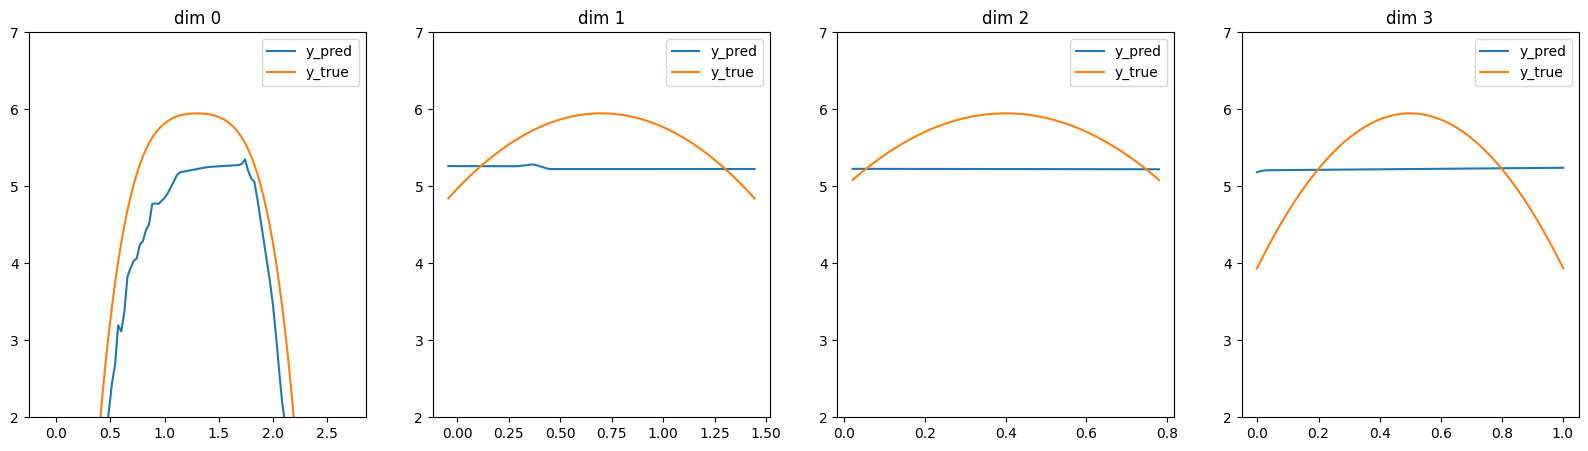

In [23]:
# plot values around the theoretical minimum of attr2 for each dimension
fig, ax = plt.subplots(ncols=attr2_dimension, figsize=(20, 5))
for i in range(attr2_dimension):
    ax[i].plot(values_df[values_df['dim']==i]['v'], values_df[values_df['dim']==i]['y_pred'], label='y_pred')
    ax[i].plot(values_df[values_df['dim']==i]['v'], values_df[values_df['dim']==i]['y_true'], label='y_true')
    ax[i].set_title(f'dim {i}')
    ax[i].set_ylim([2, 7])
    ax[i].legend()

# Downstream task: edge weight maximization
Use a naive gradient ascent to find the optimal value of attr2, given attr1 and an model trained for the edge weight between attr1 and attr2.

> **TODO**: use a modern gradient ascent method instead of the naive one.

In [24]:
# Given attr1, find attr2 such that the objective function is maximized
# with gradient ascent for the final layer

In [25]:
layer = model.get_layer(name='predicted_y')
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(inputs):
    activation = feature_extractor(inputs)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    return tf.reduce_mean(activation)

@tf.function
def gradient_ascent_step(input_attr1, input_attr2, learning_rate):
    inputs = {'attr1': input_attr1, 'attr2': input_attr2}
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        loss = feature_extractor(inputs)
    # Compute gradients.
    _grads = tape.gradient(loss, input_attr2)
    # Normalize gradients.
    grads = tf.math.l2_normalize(_grads)
    input_attr2 += learning_rate * grads
    # clip the values of input_attr2 to the range of attr2
    input_attr2 = tf.clip_by_value(input_attr2, attr2_min, attr2_max)
    return loss, input_attr2, grads, _grads

In [26]:
# constraint of attr2 by the observed min and max values
attr2_min = np.min(attr2, axis=0)
attr2_max = np.max(attr2, axis=0)

In [27]:
def visualize_attr2(input_attr1, input_attr2, epochs, steps_per_epoch, learning_rate):
    if input_attr2 is None:
        # assign random values to input_attr2
        input_attr2 = tf.random.uniform(
            minval=attr2_min,
            maxval=attr2_max,
            shape=(input_attr1.shape[0], attr2_dimension)
        )
        # assign 0.5 to input_attr2
        # input_attr2 = tf.ones(shape=(input_attr1.shape[0], attr2_dimension))*0.5
        # input_attr2 = tf.constant([[1.3, 0.7, 0.4, 0.5] for _ in range(input_attr1.shape[0])])
    # plot the loss each step
    for epoch in range(epochs):
        with tqdm(total=steps_per_epoch) as pbar:
            for step in range(steps_per_epoch):
                loss, input_attr2, ngrad, grads = gradient_ascent_step(input_attr1, input_attr2, learning_rate)
                avg_loss = tf.reduce_mean(loss)
                pbar.desc = "[Epoch %d/%d]Loss at step %d: %.2f" % (epoch, epochs, step, avg_loss)
                pbar.update(1)

    return loss, input_attr2, ngrad, grads

# # try run one gradient ascent step
# input_attr2 = tf.random.uniform(shape=(1, attr2_dimension))
# loss, x, grad = gradient_ascent_step(attr1_test[:1], input_attr2, 0.01)
# # clip the values of x to the range of attr2
# x = tf.clip_by_value(x, attr2_min, attr2_max)

In [28]:
loss, estimated_attr2, ngrad, grads = visualize_attr2(attr1_test, None, epochs=10, steps_per_epoch=100, learning_rate=0.3)
display(grads)
display(estimated_attr2)

[Epoch 9/10]Loss at step 99: 4.88: 100%|##########| 100/100 [00:00<00:00, 604.21it/s]


<tf.Tensor: shape=(4177, 4), dtype=float32, numpy=
array([[-3.2157819e+00, -9.9420659e-03,  9.1739297e-02, -4.0492496e-01],
       [ 2.4200141e+00, -5.6070507e-01,  2.5013596e-01,  2.1672152e-01],
       [ 8.8972330e-02,  2.7507113e-04, -2.5381881e-03,  1.1203221e-02],
       ...,
       [-5.2359247e+00, -1.6187636e-02,  1.4936960e-01, -6.5929735e-01],
       [ 2.6550686e-01,  8.2085381e-04, -7.5743361e-03,  3.3432100e-02],
       [-5.2359247e+00, -1.6187636e-02,  1.4936960e-01, -6.5929735e-01]],
      dtype=float32)>

<tf.Tensor: shape=(4177, 4), dtype=float32, numpy=
array([[0.8507075 , 0.8131396 , 0.30410632, 0.48780945],
       [1.8091276 , 0.32369274, 0.34067693, 0.6079479 ],
       [1.6800827 , 1.0115705 , 0.4238375 , 0.11495433],
       ...,
       [1.745169  , 0.25072202, 0.35150665, 0.6796882 ],
       [1.3346506 , 0.99028915, 0.0868203 , 0.5062498 ],
       [1.7891804 , 0.98829687, 0.11719418, 0.11951672]], dtype=float32)>

In [29]:
pd.DataFrame(
    estimated_attr2.numpy()
)

,0,1,2,3
0,0.850707,0.813140,0.304106,0.487809
1,1.809128,0.323693,0.340677,0.607948
2,1.680083,1.011570,0.423838,0.114954
3,1.805454,0.715001,0.397990,0.514835
4,0.234376,1.301617,0.125735,0.249694
...,...,...,...,...
4172,0.842307,0.892561,0.373348,0.365590
4173,0.851476,0.818296,0.567468,0.374151
4174,1.745169,0.250722,0.351507,0.679688
4175,1.334651,0.990289,0.086820,0.506250


In [30]:
pd.DataFrame(
    estimated_attr2.numpy() - np.array([1.3, 0.7, 0.4, 0.5]).reshape((1, -1)).repeat(estimated_attr2.shape[0], axis=0)
).describe()

,0,1,2,3
count,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.004527,0.062665,-0.016628,-0.014426
std,0.564688,0.424357,0.222952,0.289988
min,-1.298000,-0.699000,-0.399500,-0.498500
25%,-0.463174,-0.307471,-0.210629,-0.260067
50%,0.189112,0.052418,-0.016040,-0.008044
75%,0.483008,0.435718,0.174040,0.228117
max,1.525500,0.788000,0.360000,0.505000


In [31]:
mean_squared_error(
    estimated_attr2.numpy(),
    np.array([1.3, 0.7, 0.4, 0.5]).reshape((1, -1)).repeat(estimated_attr2.shape[0], axis=0),
    multioutput='raw_values',
)

array([0.31881665, 0.18396241, 0.04997217, 0.08428113])